# Homework 2
Zach Bogart, Josh Feldman

TODO

- Explain cross-val setup
    - explain accuracy metrics
- For hyperparam tuning:
    - Record and explain in your markdown how your evaluation metrics change as a function of these parameters. Include plots!
- include MAE in the result metrics
- do sample size tuning
    - record change in acc and runtime
    - Does overall accuracy change?
    - How does run-time scale with data size?
- color plots?
- run on larger dataset (might take a while)


In this homework, we are trying to create movie recommendations for users based on the MovieLens dataset. We want to create recommendations that are relevant to the users, giving new movies thay have not seen, but might enjoy since other users with similar watch patterns have rated them highly.

In [1]:
import pandas as pd
import numpy as np
# import implicit
# import nmslib
from scipy.sparse import csr_matrix

from surprise import NMF, KNNBasic, KNNWithMeans
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import Reader


from sklearn import model_selection
from surprise.model_selection import train_test_split

import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('seaborn-whitegrid')






Here we read in the data:

In [2]:
# dataFolder = 'ml-latest-small'
dataFolder = 'ml-latest-small'
links = pd.read_csv(dataFolder + '/links.csv')
movies = pd.read_csv(dataFolder + '/movies.csv')
ratings = pd.read_csv(dataFolder + '/ratings.csv')
tags = pd.read_csv(dataFolder + '/tags.csv')

Once the data is read in, we create training and testing sets:

In [3]:
ratingsAllDF = ratings[['userId', 'movieId', 'rating']]

ratingsTrainDF, ratingsTestDF = model_selection.train_test_split(ratingsAllDF, test_size=0.2, random_state=324)


In [4]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
ratingsTrainDataset = Dataset.load_from_df(ratingsTrainDF, reader)
# ratingsTrain = ratingsTrainDataset.build_full_trainset()

In [5]:
ratingsTest = np.asarray(ratingsTestDF)
# ratingsTrain, ratingsTest = train_test_split(ratingsData, test_size=.0)
# ratingsTest

In [6]:
print('Train data: {}'.format(ratingsTrainDataset.df.shape[0]))
print('Test data: {}'.format(len(ratingsTest)))


Train data: 80668
Test data: 20168


In [7]:
def runModel(ratings, model, paramGrid):
    
    crossValidationSplits = 5
    gridSearch = GridSearchCV(model, paramGrid, measures=['rmse', 'mae'], cv=crossValidationSplits)
    
    gridSearch.fit(ratings)
    
    return gridSearch

We now have a setup where we can pass in a model, cross-validate the desired hyperparameters, and report accuracy metrics based on those choices to find the best setup.

## Matrix Factorization Method

In [8]:
model = NMF
# paramGrid = {
#     'n_epochs': [10, 25, 50, 75], 
#     'n_factors': [5, 15, 30, 45],
#     'reg_pu': [0.1, 0.3, 0.5],
#     'reg_qi': [0.1, 0.3, 0.5],
#     'biased': [True, False],
#     'random_state': [42],
# }
paramGrid_nmf = {
    'n_epochs': [10], 
    'n_factors': [5],
    'reg_pu': [0.1],
    'reg_qi': [0.1],
    'biased': [True, False],
    'random_state': [42],
}
gridSearch_nmf = runModel(ratingsTrainDataset, model, paramGrid_nmf)

In the NMF setup, there are a set of parameters we can tune:

- n_epochs: number of iterations of stochastic gradient descent
- n_factors: number of intermediate factors
- reg_pu, reg_qi: regularization coefficients
- biased: whether to use baselines

In [20]:
def plotParameterResults(gridSearch, paramGrid):
    for param in paramGrid.keys():
        if param == 'random_state' or param == 'verbose':
            continue
        for resultType in ['mean_test_mae', 'mean_test_rmse']:
            x = [result for result in gridSearch.cv_results['param_{}'.format(param)]]
            y = [result for result in gridSearch.cv_results[resultType]]

            plt.plot(x, y, 'o', color='black')
            plt.title('Matrix Factorization Model')
            plt.xlabel(param)
            plt.ylabel(resultType)
            plt.show()
            plt.close()

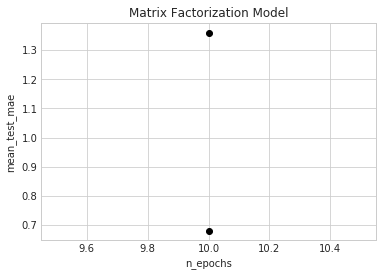

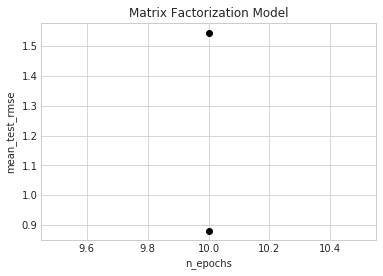

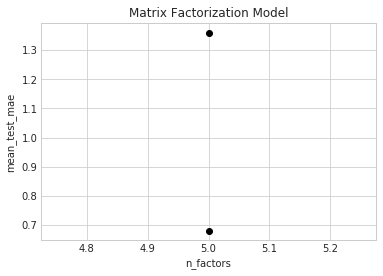

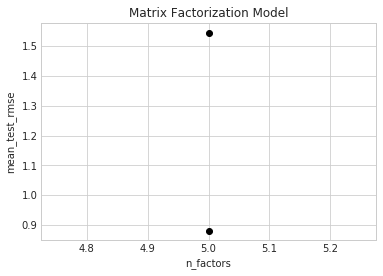

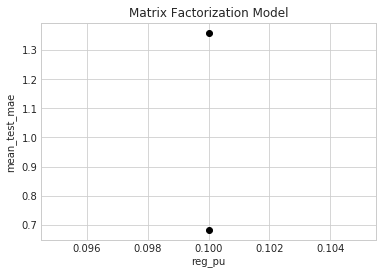

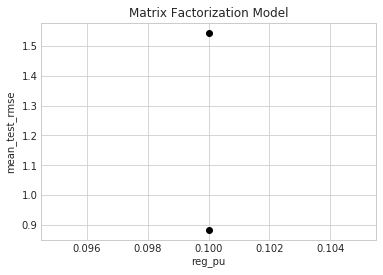

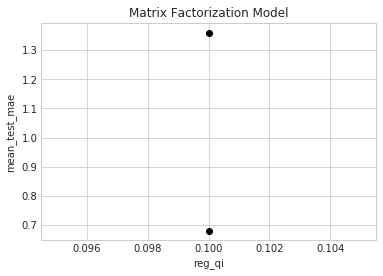

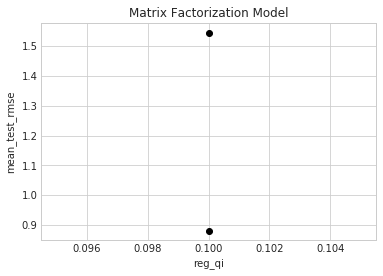

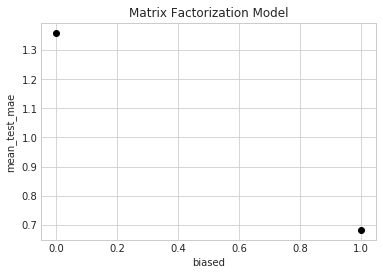

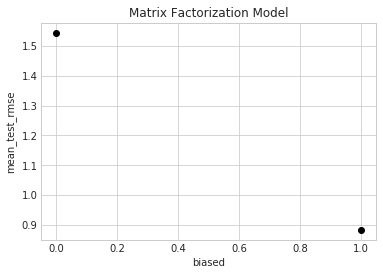

In [10]:
plotParameterResults(gridSearch_nmf, paramGrid_nmf)

In [11]:
# best RMSE score
print('The best RMSE is {}'.format(gridSearch_nmf.best_score['rmse']))

# combination of parameters that gave the best RMSE score
print('The best params are {}'.format(gridSearch_nmf.best_params['rmse']))

The best RMSE is 0.881211514000157
The best params are {'n_epochs': 10, 'n_factors': 5, 'reg_pu': 0.1, 'reg_qi': 0.1, 'biased': True, 'random_state': 42}


In [13]:
print(gridSearch_nmf.cv_results)

{'split0_test_rmse': array([0.88436523, 1.54377594]), 'split1_test_rmse': array([0.87983418, 1.5380938 ]), 'split2_test_rmse': array([0.8779371 , 1.54488172]), 'split3_test_rmse': array([0.88542375, 1.55014913]), 'split4_test_rmse': array([0.87849731, 1.54716957]), 'mean_test_rmse': array([0.88121151, 1.54481403]), 'std_test_rmse': array([0.00308787, 0.00400639]), 'rank_test_rmse': array([1, 2]), 'split0_test_mae': array([0.68176953, 1.35911322]), 'split1_test_mae': array([0.68163586, 1.35140856]), 'split2_test_mae': array([0.67509548, 1.35959234]), 'split3_test_mae': array([0.68472195, 1.36636099]), 'split4_test_mae': array([0.68012794, 1.3613984 ]), 'mean_test_mae': array([0.68067015, 1.3595747 ]), 'std_test_mae': array([0.00316004, 0.00482242]), 'rank_test_mae': array([1, 2]), 'mean_fit_time': array([0.7746562 , 0.69721632]), 'std_fit_time': array([0.08872054, 0.03906815]), 'mean_test_time': array([0.14039254, 0.10669622]), 'std_test_time': array([0.0362773 , 0.02558867]), 'params':

## Neighborhood Method

In [25]:
model = KNNWithMeans
paramGrid_knn = {
    'k': [5, 10, 20, 40, 80, 100], 
    'min_k': [1, 3, 5],
    'verbose': [False]
}
gridSearch_knn = runModel(ratingsTrainDataset, model, paramGrid_knn)

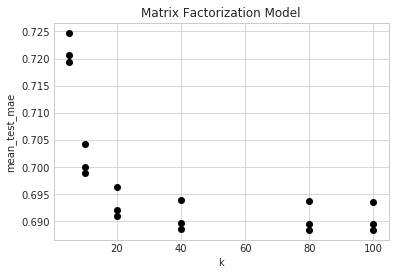

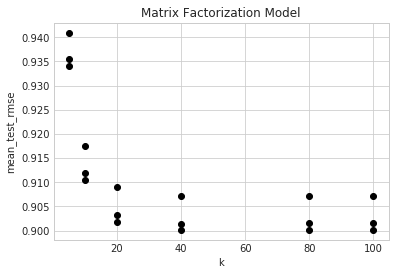

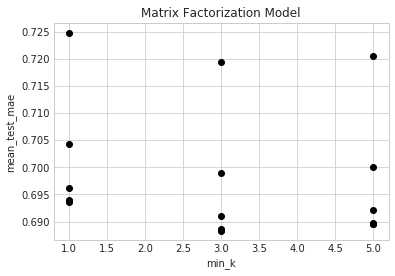

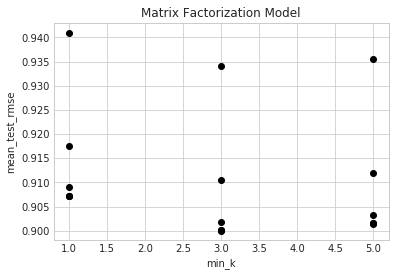

In [26]:
plotParameterResults(gridSearch_knn, paramGrid_knn)

In [27]:
gridSearch_knn.best_params

{'rmse': {'k': 40, 'min_k': 3, 'verbose': False},
 'mae': {'k': 100, 'min_k': 3, 'verbose': False}}

In [28]:
# best RMSE score
print('The best RMSE is {}'.format(gridSearch_knn.best_score['rmse']))

# combination of parameters that gave the best RMSE score
print('The best params are {}'.format(gridSearch_knn.best_params['rmse']))

The best RMSE is 0.9000430857076189
The best params are {'k': 40, 'min_k': 3, 'verbose': False}


## Tune Sample Size

In [36]:
scales = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

def tune_sample_size(bestModel, bestParamGrid, scales, ratingsTrainDF):

    scores = []

    for scale in scales:
        ratingsTrainSampledDF = ratingsTrainDF.sample(frac=scale, random_state=833)
        numRatings = ratingsTrainSampledDF.shape[0]
        # print('')
        # print('Using {} ratings'.format(numRatings))

        reader = Reader(rating_scale=(1, 5))
        ratingsTrainDataset = Dataset.load_from_df(ratingsTrainSampledDF, reader)

    #     model = NMF
    #     bestParamGrid = {
    #         'n_epochs': [10], 
    #         'n_factors': [5],
    #         'reg_pu': [0.1],
    #         'reg_qi': [0.1],
    #         'biased': [True],
    #         'random_state': [234],
    #     }
        gridSearch = runModel(ratingsTrainDataset, bestModel, bestParamGrid)

        # best RMSE score
        bestScore = gridSearch.best_score['rmse']
        # print('The best RMSE of {}'.format(bestScore))
        scores.append(bestScore)
        
    return scores

In [38]:
bestParamGrid_nmf = {
            'n_epochs': [10], 
            'n_factors': [5],
            'reg_pu': [0.1],
            'reg_qi': [0.1],
            'biased': [True],
            'random_state': [234],
        }

scores_nmf = tune_sample_size(NMF, bestParamGrid_nmf, scales, ratingsTrainDF)

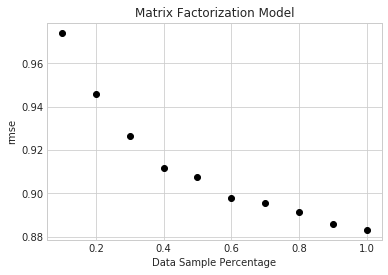

In [40]:
plt.plot(scales, scores_nmf, 'o', color='black')
plt.title('Matrix Factorization Model')
plt.xlabel('Data Sample Percentage')
plt.ylabel('rmse')
plt.show()
plt.close()

In [42]:
bestParamGrid_knn = {
            'k': [40], 
            'min_k': [3],
            'verbose': [False]
        }

scores_nmf = tune_sample_size(KNNWithMeans, bestParamGrid_knn, scales, ratingsTrainDF)

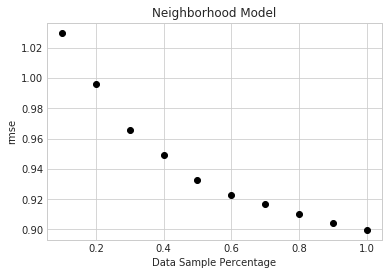

In [43]:
plt.plot(scales, scores_nmf, 'o', color='black')
plt.title('Neighborhood Model')
plt.xlabel('Data Sample Percentage')
plt.ylabel('rmse')
plt.show()
plt.close()

For both models, as we sample more data, the error metric decreases